# Notebook Imports

In [138]:
from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, f1_score

%matplotlib inline

# Constants

In [65]:
SPAM_1_PATH = "C:/Users/Enes/ML projects/SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "C:/Users/Enes/ML projects/SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "C:/Users/Enes/ML projects/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "C:/Users/Enes/ML projects/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

TRAINING_DATA_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/test-data.txt"

TOKEN_SPAM_PROB_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/prob-spam.txt"
TOKEN_HAM_PROB_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/prob-nonspam.txt"
TOKEN_ALL_PROB_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/prob-all-tokens.txt"

TEST_FEATURE_MATRIX = "C:/Users/Enes/ML projects/SpamData/02_Training/test-features.txt"
TEST_TARGET_FILE = "C:/Users/Enes/ML projects/SpamData/02_Training/test-target.txt"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "C:/Users/Enes/ML projects/SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "C:/Users/Enes/ML projects/SpamData/01_Processing/word-by-id.csv"

## Email body extraction

In [22]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1' )

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [23]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [24]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

In [25]:
data = pd.concat([spam_emails, ham_emails])

# Data Cleaning: Checking for Missing Values

In [26]:
data["MESSAGE"].isnull().values.any() # False but not null maybe there is empty string

False

In [27]:
(data.MESSAGE.str.len() == 0).any() # Yes there it is

True

In [28]:
(data.MESSAGE.str.len() == 0).sum() # Showing us to how many empty string is there

3

In [29]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [30]:
data.index.get_loc("cmds")

array([False, False, False, ..., False, False, False])

### Remove System File Entries from DataFrame

In [31]:
data.drop(['cmds'], inplace=True)
data.shape

(5796, 2)

# Adding Document IDs to Track Emails in Dataset

In [32]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [33]:
data["FILE_NAME"] = data.index
data.set_index("DOC_ID", inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


## Save to File using Pandas

In [36]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [37]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

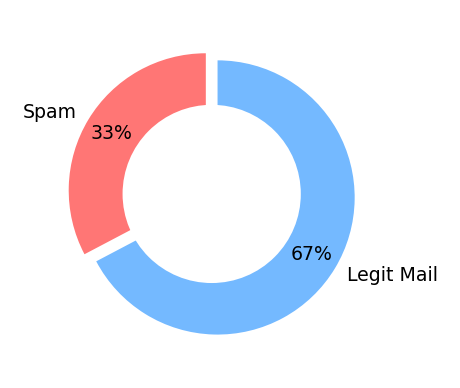

In [38]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ["#ff7675", "#74b9ff"]


plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names,
        textprops={"fontsize": 6},
        startangle=90, autopct="%1.0f%%",
        colors=custom_colors, pctdistance=0.8, explode=[0.05, 0.05])

# Drawing circle
center_circle = plt.Circle((0, 0), radius=0.65, fc="white")
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

### Download the NLTK Resources (Tokenizer & Stopwords)

In [40]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Enes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Function for Email Processing

In [41]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words("english"))):
    
    # Remove HTML tags
    message = BeautifulSoup(message, "html.parser").get_text()
    
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [43]:
%%time

# Use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

D:\Users\Enes\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 48.8 s


### Slice Dataframes

In [45]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

nested_list_ham = nested_list[doc_ids_ham]
nested_list_spam = nested_list[doc_ids_spam]

In [46]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

normal_words = pd.Series(flat_list_ham).value_counts()
spam_words = pd.Series(flat_list_spam).value_counts()

print("Total number of unique words in non-spam messages: ", normal_words.shape[0])
print("Total number of unique words in spam messages: ", spam_words.shape[0])

Total number of unique words in non-spam messages:  20815
Total number of unique words in spam messages:  13242


In [47]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [48]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Generating a Vocabulary

In [49]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

D:\Users\Enes\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [50]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Nr of unique words ", unique_words.shape[0])
unique_words.head()

Nr of unique words  27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [51]:
frequent_words = unique_words[:VOCAB_SIZE]
print("Most common words : \n", frequent_words[:10])

Most common words : 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary Dataframe with a WORD_ID

In [52]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD": frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


### Save the Vocab as a csv file

In [55]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Generate Features & a Sparse Matrix

## Creating a DataFrame With one Word per Column

In [56]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.shape

(5796, 7671)

# Splitting the Data into a Training and Testing Dataset

In [58]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [59]:
X_train.index.name = X_test.index.name = "DOC_ID"
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Create a Sparse Matrix for the Training Data

In [62]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [63]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index(X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train r y_test)
    
    """
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {"LABEL": category, "DOC_ID": doc_id,
                        "OCCURENCE": 1, "WORD_ID": word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [64]:
%%time 
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 17min 16s


In [66]:
sparse_train_df.shape

(429223, 4)

### Combine Occurences

In [67]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()

### Save Training Data as .txt File

In [68]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt="%d")
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

## Create a Sparse Matrix for the Test Data

In [69]:
%%time 
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 6min 58s


In [70]:
sparse_test_df.shape

(203386, 4)

### Combine Occurences

In [71]:
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()

### Save Test Data as .txt File

In [72]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt="%d")

# Read and Load Features from .txt into NumPy Array

In [73]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=" ", dtype=int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter=" ", dtype=int)

In [74]:
print("Nr of rows in training file ", sparse_train_data.shape[0])
print("Nr of rows in test file ", sparse_test_data.shape[0])
print("Nr of emails in training file", np.unique(sparse_train_data[:, 0]).size)
print("Nr of emails in test file", np.unique(sparse_test_data[:, 0]).size)

Nr of rows in training file  258366
Nr of rows in test file  117780
Nr of emails in training file 4013
Nr of emails in test file 1724


### Create an Empty DataFrame

In [75]:
column_names = ["DOC_ID"] + ["CATEGORY"] + list(range(0, VOCAB_SIZE))

In [76]:
index_names = np.unique(sparse_train_data[:, 0])

In [77]:
full_train_data = pd.DataFrame(index=index_names, columns=column_names)
full_train_data.fillna(value=0, inplace=True) # normally it becomes with NaN

In [78]:
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create a Full Matrix from a Sparse Matrix

In [79]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx=0,
                     word_idx=1, cat_idx=2, freq_idx=3):
    """
    Form a full matrix from a sparse matrix. Return a pandas dataframe.
    Keyword Arguments:
    sparse_matrix -- numpy array.
    nr_words -- size of the vocabulary. Total number of tokens.
    doc_idx -- position of the document id in the sparse matrix. Default: 1st
    word_idx -- position of the word id in the sparse matrix. Default: 2nd 
    cat_idx -- positin of the category in the sparse matrix. Default: 3nd
    freq_idx -- position of occurrence of word in sparse matrix. Default: 4th
    """
    
    column_names = ["DOC_ID"] + ["CATEGORY"] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:, 0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurrence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, "DOC_ID"] = doc_nr
        full_matrix.at[doc_nr, "CATEGORY"] = label
        full_matrix.at[doc_nr, word_id] = occurrence
        
    full_matrix.set_index("DOC_ID", inplace=True)
    
    return full_matrix

In [81]:
%%time
full_train_data = make_full_matrix(sparse_matrix=sparse_train_data, nr_words=VOCAB_SIZE)

Wall time: 14.7 s


In [82]:
full_train_data.tail()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5789,0,3,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5790,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5791,0,3,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5794,0,1,1,1,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5795,0,3,4,2,0,5,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training the Naive Bayes Model

In [85]:
full_train_features = full_train_data.loc[:, full_train_data.columns != "CATEGORY"]
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4013,)

In [86]:
total_wc = email_lengths.sum()

## Number of Tokens in Spam & Ham Emails

In [92]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_wc = spam_lengths.sum()

In [93]:
ham_lengths = email_lengths[full_train_data.CATEGORY == 0]
nonspam_wc = ham_lengths.sum()

In [94]:
print("Average nr of words in spam emails {:.3f}".format(spam_wc / spam_lengths.shape[0]))
print("Average nr of words in non-spam emails {:.3f}".format(nonspam_wc / ham_lengths.shape[0]))

Average nr of words in spam emails 141.291
Average nr of words in non-spam emails 91.462


# Summing the Tokens Occuring in Spam

In [87]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) + 1
summed_spam_tokens.shape

(2500,)

# Summing the Tokens Occuring in non-Spam

In [89]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
train_ham_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1896,1,2,1,0,1,1,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1898,2,1,0,1,1,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1899,2,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1900,3,4,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1901,2,2,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1
summed_ham_tokens.shape

(2500,)

## P(Token | Spam) - Probability that a Token occurs given the Email is Spam

In [98]:
prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_tokens_spam.sum()

1.0

## P(Token | Ham) - Probability that a Token occurs given the Email is Non-Spam

In [97]:
prob_tokens_nonspam = summed_ham_tokens / (nonspam_wc + VOCAB_SIZE)
prob_tokens_nonspam.sum()

1.0

# P(Token) - Probability that Token Occurs

In [100]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc
prob_tokens_all.sum()

1.0

# Save the Trained Model

In [101]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE, prob_tokens_nonspam)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

# Prepare Test Data

In [102]:
%%time
full_test_data = make_full_matrix(sparse_matrix=sparse_test_data, nr_words=VOCAB_SIZE)

Wall time: 6.96 s


In [103]:
full_test_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
8,1,0,0,1,4,2,1,2,4,1,...,0,0,0,0,0,0,0,0,0,0
12,1,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,0,2,1,1,2,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
17,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [104]:
X_test = full_test_data.loc[:, full_test_data.columns != "CATEGORY"]
y_test = full_test_data.CATEGORY

In [105]:
np.savetxt(TEST_TARGET_FILE, y_test)
np.savetxt(TEST_FEATURE_MATRIX, X_test)

# Load the Data

In [107]:
# Features
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=" ")
# Target
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=" ")
# Token Probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=" ")
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter=" ")
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter=" ")

# Calculating the Joint Probability

## Set the Prior

$$(Spam \, | \, X) = \frac{P(X \, | \, Spam \,) \, P(Spam)} {P(X)}$$

In [108]:
prob_spam = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size

## Joint probability in log format

In [111]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(prob_spam)

$$(Ham \, | \, X) = \frac{P(X \, | \, Ham \,) \, (1 - P(Spam))} {P(X)}$$

In [113]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1 - prob_spam)

# Making Predictions

### Checking for the higher joint probability

$$P(Spam \, | \, X) > \, P(Ham \, | \, X)$$
<br>
<center>OR</center>
<br>
$$P(Spam \, | \, X) < \, P(Ham \, | \, X)$$

In [114]:
prediction = joint_log_spam > joint_log_ham

In [115]:
prediction[-5:]*1

array([1, 0, 0, 0, 0])

In [116]:
y_test[-5:]

array([0., 0., 0., 0., 0.])

## Simplify

In [118]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(prob_spam)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1-prob_spam)

# Metrics and Evaulation

## Accuracy

In [119]:
correct_docs = (y_test == prediction).sum()
print("Docs classified correctly", correct_docs)
numdocs_wrong = X_test.shape[0] - correct_docs
print("Docs classfied incorrectly", numdocs_wrong)

Docs classified correctly 1685
Docs classfied incorrectly 39


In [121]:
# Accuracy
fraction_wrong = numdocs_wrong/len(X_test)
print("Fraction classified incorrectly is {:.2%}".format(fraction_wrong))
print("Accuracy of the model is {:.2%}".format(1 - fraction_wrong))

Fraction classified incorrectly is 2.26%
Accuracy of the model is 97.74%


## Visualising the Results

In [122]:
# Chart Styling info
yaxis_label = "P(X | Spam)"
xaxis_label = "P(X | non-Spam)"

linedata = np.linspace(start=-14000, stop=1, num=1000)

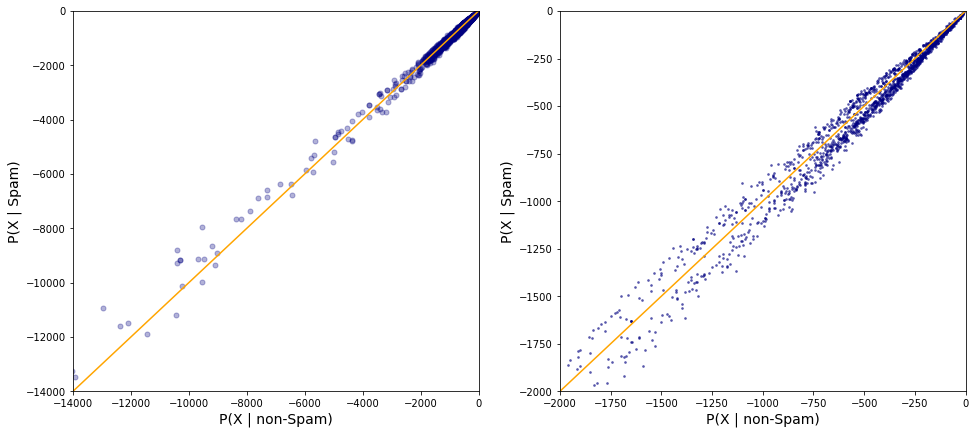

In [123]:
plt.figure(figsize=(16, 7))

# Chart nr 1
plt.subplot(1, 2, 1)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Setting scale
plt.xlim([-14000, 1])
plt.ylim([-14000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color="navy", alpha=0.3, s=25)
plt.plot(linedata, linedata, color="orange")

# Chart nr 2
plt.subplot(1, 2, 2)

plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# Setting scale
plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.scatter(joint_log_ham, joint_log_spam, color="navy", alpha=0.5, s=3)
plt.plot(linedata, linedata, color="orange")

plt.show()

In [124]:
# Chart Styling
sns.set_style("whitegrid")
labels = "Actual Category"

summary_df = pd.DataFrame({yaxis_label: joint_log_spam, xaxis_label: joint_log_ham,
                          labels: y_test})

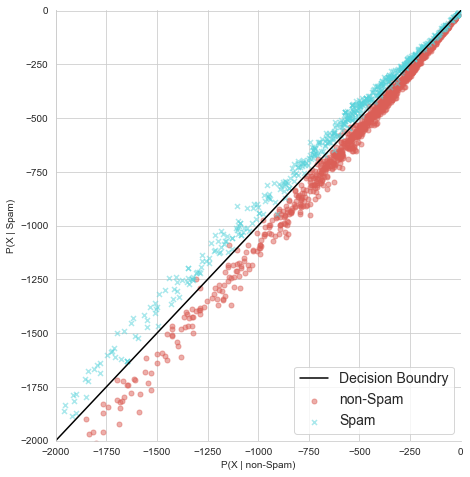

In [129]:
sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, height=6.5, fit_reg=False, legend=False,
          scatter_kws={"alpha": 0.5, "s": 25}, hue=labels, markers=["o", "x"],
          palette="hls")

plt.xlim([-2000, 1])
plt.ylim([-2000, 1])

plt.plot(linedata, linedata, color="black")

plt.legend(("Decision Boundry", "non-Spam", "Spam"), loc="lower right", fontsize=14)

plt.show()

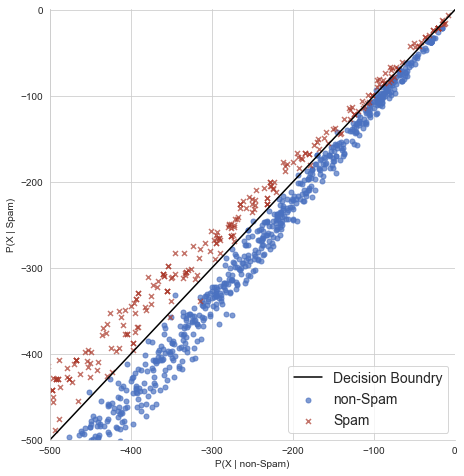

In [128]:
my_colors = ["#4A71C0", "#AB3A2C"]

sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, height=6.5, fit_reg=False, legend=False,
          scatter_kws={"alpha": 0.7, "s": 25}, hue=labels, markers=["o", "x"],
          palette=my_colors)

plt.xlim([-500, 1])
plt.ylim([-500, 1])

plt.plot(linedata, linedata, color="black")

plt.legend(("Decision Boundry", "non-Spam", "Spam"), loc="lower right", fontsize=14)

plt.show()

### False Positives and False Negatives

In [131]:
np.unique(prediction, return_counts=True)

(array([False,  True]), array([1136,  588], dtype=int64))

In [135]:
true_pos = (y_test == 1) & (prediction == 1)
true_pos.sum()

569

In [136]:
false_pos = (y_test == 0) & (prediction == 1)
false_pos.sum()

19

In [137]:
false_neg = (y_test == 1) & (prediction == 0)
false_neg.sum()

20

# Naive Bayes with scikit-learn

In [143]:
vectorizer = CountVectorizer(stop_words="english")
all_features = vectorizer.fit_transform(data.MESSAGE)
all_features.shape

(5796, 102694)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(all_features, data.CATEGORY,
                                                   test_size=0.3, random_state=88)

In [147]:
classifier = MultinomialNB()

In [148]:
classifier.fit(X_train, y_train)

MultinomialNB()

In [149]:
nr_correct = (y_test == classifier.predict(X_test)).sum()
print(f"{nr_correct} documents classified correctly")

1641 documents classified correctly


In [150]:
nr_incorrect = y_test.size - nr_correct
print(f"Number of documents incorrectly classified is {nr_incorrect}")

Number of documents incorrectly classified is 98


In [151]:
fraction_wrong = nr_incorrect / (nr_correct + nr_incorrect)
print(f"The (testing) accuracy of the model is {1-fraction_wrong:.2%}")

The (testing) accuracy of the model is 94.36%


In [152]:
# Model Accuracy
classifier.score(X_test, y_test)

0.9436457734330075

In [154]:
# Recall Score
recall_score(y_test, classifier.predict(X_test))

0.8303249097472925

In [155]:
# Precision Score
precision_score(y_test, classifier.predict(X_test))

0.9913793103448276

In [160]:
# F1 score
f1_score(y_test, classifier.predict(X_test))

0.9037328094302555

## Make prediction with an example list

In [157]:
example = ["get viagra for free now!",
          "need a mortgage? Reply to arrange a call with a specialist and get a quote",
          "Hey do you want to get some free money click the link in below!",
          "Could you please help me with the project for tomarrow",
          "Hello john, how about a game of golf tomorrow",
          "Ski jumping is a winter sport in which competitors aim to achieve the longest jump after descending from a specially designed ramp on their skis. Along with jump length, competitor's style and other factors affect the final score. Ski jumping was first contested in Norway in the late 19th century, and later spread through Europe and North America in the early 20th century. Along with cross-country skiing, it constitutes the traditional group of Nordic skiing disciplines."]

In [ ]:
doc_term_matrix = vectorizer.transform(example)

### Prediction seems correct (1 for Spam 0 for non-Spam)

In [159]:
classifier.predict(doc_term_matrix)

array([1, 1, 1, 0, 0, 0], dtype=int64)